In [1]:
from pathlib import Path
from datetime import datetime
import json

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.reset_defaults()
sns.set()

print('Physical Devices:')
for dev in tf.config.list_physical_devices():
    print(dev)

2024-04-22 18:18:05.674824: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 18:18:06.301183: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 18:18:06.301278: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 18:18:06.399427: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-22 18:18:06.600784: I tensorflow/core/platform/cpu_feature_guar

Physical Devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-04-22 18:18:10.876908: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 18:18:11.285190: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 18:18:11.285273: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
from zscomm.agent import Agent
from zscomm.comm_channel import CommChannel
from zscomm.synth_teacher import SyntheticTeacher
from zscomm.data import *
from zscomm.play_game import *
from zscomm.loss import *
from zscomm.experiment import Experiment
from zscomm.meta_experiment import *
from zscomm.vary_play_param_experiment import *
from zscomm.plot_game import plot_game
from zscomm.analysis import *

## Load Data:

In [5]:
NUM_CLASSES = 3
CHANNEL_SIZE = 5
BATCH_SIZE = 32

TRAIN_DATA, TEST_DATA = get_simple_card_data(num_classes=NUM_CLASSES)

In [6]:
def generate_train_batch():
    return generate_batch(TRAIN_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)


def generate_test_batch():
    return generate_batch(TEST_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)

In [7]:
def create_channel_subset_permutation_experiment(
    permutation_subset_size=3, **experiment_kwargs
):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES)

    start_temp = 10
    end_temp = 0.1
    temp_anneal_end_epoch = 200
    a = -np.log(end_temp / start_temp) / temp_anneal_end_epoch
    
    def play_params(epoch):
        if epoch < temp_anneal_end_epoch:
            channel_temp = float(start_temp * np.exp(-a*epoch))
        else:
            channel_temp = end_temp
        
        return {
            'channel_size': CHANNEL_SIZE,
            'p_mutate': 0,
            'message_permutation': True,
            'permutation_subset_size': permutation_subset_size,
            'channel_temp': channel_temp,
        }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=student_pred_matches_test_class,
        lr=1e-2,
        name='channel_subset_permutation',
        **experiment_kwargs
    )

# Run Experiments

In [3]:
BASE_FOLDER = './experiments/subset_permutation'
Path(BASE_FOLDER).mkdir(exist_ok=True)

# EXPERIMENT_FOLDER = f'{BASE_FOLDER}/{datetime.now().strftime("%d-%m_%H-%M")}'

# EXPERIMENT_FOLDER = "./experiments/message_mutation_3"
# EXPERIMENT_FOLDER = "./experiments/message_mutation_1/24-09_09-40"
# EXPERIMENT_FOLDER = "./experiments/message_mutation_1/03-10_02-03"

EXPERIMENT_FOLDER = "./experiments/subset_permutation/07-10_02-11"
Path(EXPERIMENT_FOLDER).mkdir(exist_ok=True)
EXPERIMENT_FOLDER

'./experiments/subset_permutation/07-10_02-11'

In [10]:
experiment = VaryPlayParamExperiment(
    save_location=EXPERIMENT_FOLDER,
    param_vals=[2, 3, 4, 5],
    param_name='permutation_subset_size',
    max_epochs=200,
    num_experiments_per_val=3,
    create_experiment_fn=create_channel_subset_permutation_experiment
)

In [51]:
experiment.run()

Running vary_pm_experiment...
meta_experiment_permutation_subset_size=2 results:  [1.0, 0.60625, 0.45, 0.06875, 0.7375, 0.375]
meta_experiment_permutation_subset_size=3 results:  [0.71875, 0.90625, 0.9625000000000001, 1.0, 1.0, 1.0]
meta_experiment_permutation_subset_size=4 results:  [0.9375, 0.90625, 0.89375, 1.0, 1.0, 1.0]
Run Stopped.


In [52]:
grand_total = 0
for item_1 in experiment.experiments:
    for item_2 in item_1['experiment'].experiments:
        total_time = sum([
            x['seconds_taken']
            for x in item_2['experiment'].training_history
        ])
        print(int(total_time / 3600), 'hours,', int(total_time / 60) % 60, 'mins and', 
              int(total_time) % 60, 'seconds taken for experiment', 
              f"{experiment.param_name}={item_1[experiment.param_name]}_{item_2['index']}")
        grand_total += total_time
    print()
    
print(int(grand_total / 3600), 'hours,', int(grand_total / 60) % 60, 'mins and', 
      int(grand_total) % 60, 'seconds taken for whole experiment')

0 hours, 29 mins and 24 seconds taken for experiment permutation_subset_size=2_0
0 hours, 28 mins and 39 seconds taken for experiment permutation_subset_size=2_1
0 hours, 28 mins and 29 seconds taken for experiment permutation_subset_size=2_2

0 hours, 28 mins and 9 seconds taken for experiment permutation_subset_size=3_0
0 hours, 28 mins and 21 seconds taken for experiment permutation_subset_size=3_1
0 hours, 29 mins and 32 seconds taken for experiment permutation_subset_size=3_2

0 hours, 28 mins and 12 seconds taken for experiment permutation_subset_size=4_0
0 hours, 29 mins and 39 seconds taken for experiment permutation_subset_size=4_1
0 hours, 28 mins and 52 seconds taken for experiment permutation_subset_size=4_2

4 hours, 19 mins and 20 seconds taken for whole experiment


In [6]:
def load_channel_permutation_experiment(path):
    
    config = json.load((path / 'config.json').open(mode='r'))
    results = json.load((path / 'results.json').open(mode='r'))
    history = json.load((path / 'training_history.json').open(mode='r'))
    
    agent = Agent(config['play_params']['channel_size'], NUM_CLASSES)
    agent.load_weights(str(path / 'agent_weights'))
    
    config['loss_fn'] = student_pred_matches_test_class

    kwargs = {
        k: v for k, v in config.items()
        if k not in ['epochs_optimised', 
                     'optimiser_config',
                     'optimise_agents_separately']
    }
    experiment = Experiment(
        generate_train_batch, generate_test_batch,
        student=agent,
        teacher=agent,
        **kwargs
    )
    experiment.epoch = config['epochs_optimised']
    experiment.training_history = history
    experiment.results = results
    
    return experiment

In [7]:
full_permutation_experiments = []
FULL_PERMUTATION_EXPERIMENT_FOLDER = './experiments/channel_permutation_with_temp_annealing'

for path in Path(FULL_PERMUTATION_EXPERIMENT_FOLDER).glob('*'):
    if not path.is_file():
        exp = load_channel_permutation_experiment(path)
        full_permutation_experiments.append(exp)
        print('Loaded experiment from:', path)

In [76]:
with Path(f'{FULL_PERMUTATION_EXPERIMENT_FOLDER}/results.json').open(mode='r') as f:
    full_permutation_results = json.load(f)

In [74]:
full_permutation_df_train = pd.DataFrame([
    {
        'Epoch': epoch,
        'Loss': train_item['loss'],
        'Experiment': f"Run {index}"
    }
    for index, experiment in enumerate(full_permutation_experiments)
    for epoch, train_item in enumerate(experiment.training_history)
])

full_permutation_df_test = pd.DataFrame([
    {
        'Epoch': epoch,
        'Performance': train_item['test_metrics']['mean_ground_truth_f1'],
        'Protocol Diversity': train_item['test_metrics']['mean_protocol_diversity'],
        'Experiment': f"Run {index}"
    }
    for index, experiment in enumerate(full_permutation_experiments)
    for epoch, train_item in enumerate(experiment.training_history)
    if 'test_metrics' in train_item
])

In [15]:
X_NAME = 'Permuted Proportion'

In [24]:
zs_coord_df = pd.DataFrame([
    {
        X_NAME: item[experiment.param_name],
        'Zero-Shot Coordination Score': metrics['mean_ground_truth_f1'],
    }
    for item in experiment.experiments
    if item['status'] == 'Complete'
    for stranger_pairings in item['results']
    for metrics in stranger_pairings['vanilla_params_test_metrics']
])

zs_coord_training_params_df = pd.DataFrame([
    {
        X_NAME: item[experiment.param_name],
        'Zero-Shot Coordination Score': metrics['mean_ground_truth_f1'],
    }
    for item in experiment.experiments
    if item['status'] == 'Complete'
    for stranger_pairings in item['results']
    for metrics in stranger_pairings['vanilla_params_test_metrics']
])

In [39]:
_, test_metrics = experiment.experiments[-1]['experiment'].experiments[0]['experiment'].run_tests()

In [40]:
test_metrics

{'mean_test_loss': 1.1920928955078125e-07,
 'mean_ground_truth_f1': 1.0,
 'ground_truth_acc': 1.0,
 'mean_student_error': 0.3895207345485687,
 'mean_teacher_error': 10.40533447265625,
 'mean_protocol_diversity': 1.0,
 'mean_protocol_entropy': 7.222239013367687e-35}

In [56]:
# update results to compute responsiveness values (old experiments didn't store this)
for item0 in experiment.experiments:
    for item in item0['experiment'].experiments:
        def print_test_metrics(metrics):
            print(
                f"Test Loss: {round(metrics.get('mean_test_loss', np.nan), 3)},",
                f"Ground Truth F1-Score: {round(metrics.get('mean_ground_truth_f1', np.nan), 3)},",
                f"Student Error: {round(metrics.get('mean_student_error', np.nan), 3)},",
                f"Teacher Error: {round(metrics.get('mean_teacher_error', np.nan), 3)},",
                f"Protocol Diversity: {round(metrics.get('mean_protocol_diversity', np.nan), 3)},",
                f"Protocol Entropy: {round(metrics.get('mean_protocol_entropy', np.nan), 3)},"
            )
        item['experiment'].print_test_metrics = print_test_metrics
        item['experiment'].results = item['experiment'].get_results()
        item['results'] = item['experiment'].results
clear_output()

Running vary_pm_experiment...
meta_experiment_permutation_subset_size=2 results:  [1.0, 0.60625, 0.45, 0.06875, 0.7375, 0.375]
meta_experiment_permutation_subset_size=3 results:  [0.71875, 0.90625, 0.9625000000000001, 1.0, 1.0, 1.0]
meta_experiment_permutation_subset_size=4 results:  [0.9375, 0.90625, 0.89375, 1.0, 1.0, 1.0]
meta_experiment_permutation_subset_size=5 results:  [1.0, 1.0, 0.94375, 1.0, 0.8875, 1.0]
Running meta_experiment_permutation_subset_size=4...
training_params_results
Test Loss: 0.0, Ground Truth F1-Score: 1.0, Student Error: 1.41, Teacher Error: 8.454, Protocol Diversity: 1.0, Protocol Entropy: 0.0,

vanilla_params_results
Test Loss: 0.0, Ground Truth F1-Score: 1.0, Student Error: 1.222, Teacher Error: 0.219, Protocol Diversity: 1.0, Protocol Entropy: 0.0,

student_responsiveness 0.9999998781830118

teacher_responsiveness 2.1425497380640423e-05

training_params_results
Test Loss: 0.0, Ground Truth F1-Score: 1.0, Student Error: 1.276, Teacher Error: 7.675, Protocol

In [46]:
self_play_df = pd.DataFrame([
    {
        X_NAME: item_1[experiment.param_name],
        'Self-play Performance': 
            item_2['results']['training_params_results']['ground_truth_acc'],
    }
    for item_1 in experiment.experiments
    if item_1['status'] == 'Complete'
    for item_2 in item_1['experiment'].experiments
    if item_2['status'] == 'Complete'
] 
)

In [42]:
zs_coord_df.head()

,Permuted Proportion,Zero-Shot Coordination Score
0,2,1.00000
1,2,0.60625
2,2,0.45000
3,2,0.06875
4,2,0.73750


In [20]:
def get_experiment_item(experiment_path, sub_experiment_path):
    with open(sub_experiment_path / 'results.json', 'r') as f:
        results = json.load(f)
    with open(experiment_path / 'meta.json', 'r') as f:
        config = json.load(f)
    permutation_subset_size = config['experiment_config']['play_params']['permutation_subset_size']
    if 'training_params_results' in results:
        score = results['training_params_results']['ground_truth_acc']
    else:
        score = results['mean_ground_truth_f1']
    return [
        {
            X_NAME: permutation_subset_size,
            'Self-play Performance': score
        }
    ]

self_play_df = pd.DataFrame([
    item
    for p_mutate_experiment_path in Path(EXPERIMENT_FOLDER).glob('*')
    for sub_experiment_path in p_mutate_experiment_path.glob('*')
    if sub_experiment_path.is_dir()
    for item in get_experiment_item(p_mutate_experiment_path, sub_experiment_path)
])
self_play_df.head()

,Permuted Proportion,Self-play Performance
0,5,1.0
1,5,1.0
2,5,1.0
3,5,1.0
4,5,1.0


In [4]:
def get_experiment_item(experiment_path):
    with open(experiment_path / 'results.json', 'r') as f:
        results = json.load(f)
    with open(experiment_path / 'meta.json', 'r') as f:
        config = json.load(f)
    permutation_subset_size = config['experiment_config']['play_params']['permutation_subset_size']

    return [
        {
            X_NAME: permutation_subset_size,
            'Zero-Shot Coordination Score': sub_item['mean_ground_truth_f1']
        }
        for item in results
        for sub_item in item['vanilla_params_test_metrics']
    ]

zs_coord_df = pd.DataFrame([
    item
    for experiment_path in Path(EXPERIMENT_FOLDER).glob('*')
    for item in get_experiment_item(experiment_path)
])
zs_coord_df.head()

NameError: name 'pd' is not defined

In [22]:
NUM_CLASSES = 3
CHANNEL_SIZE = 5

In [23]:
sns.reset_defaults()
sns.set()

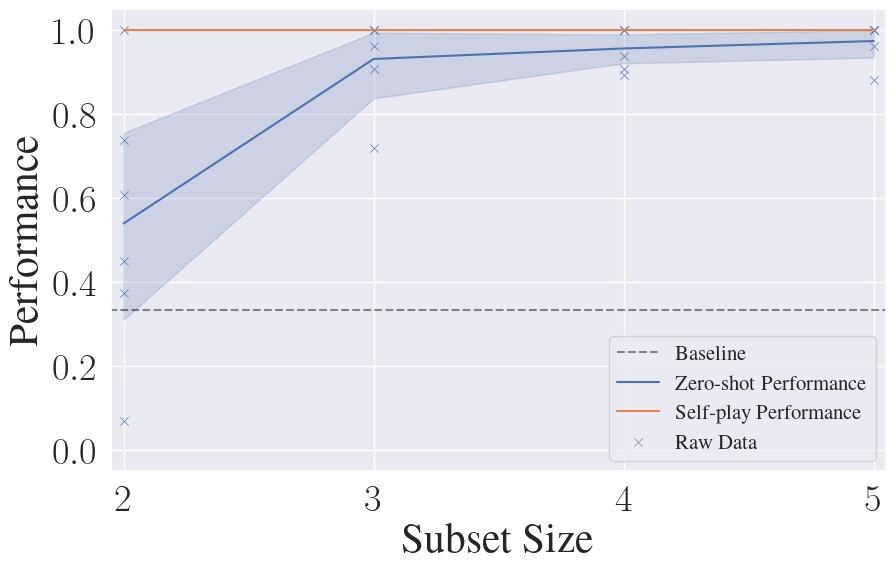

reformatted figures/channel_subset_permutations_zsc/code.py

All done! ✨ 🍰 ✨
1 file reformatted.


In [51]:
from reproducible_figures import set_plotting_style, save_reproducible_figure
# from matplotlib import rc
import matplotlib.pylab as plt


def plot_channel_subset_permutation_zsc(zs_coord_df, self_play_df):
    set_plotting_style(font_scale=2.5, rc={'legend.fontsize': 15})

    plt.figure(figsize=(10, 6))
    ax = sns.lineplot(x=[-20, 20], y=[1/NUM_CLASSES, 1/NUM_CLASSES], 
                    color=(0.1, 0.1, 0.1, 0.5), label='Baseline')
    ax.lines[0].set_linestyle("--")

    sns.lineplot(x=X_NAME, y='Zero-Shot Coordination Score', 
                data=zs_coord_df, label='Zero-shot Performance')
    sns.scatterplot(x=X_NAME, y='Zero-Shot Coordination Score', 
                    data=zs_coord_df, marker='x')

    sns.lineplot(x=X_NAME, y='Self-play Performance', 
                data=self_play_df, label='Self-play Performance')
    # sns.scatterplot(x=X_NAME, y='Self-play Performance', 
    #                 data=self_play_df, marker='x')

    sns.scatterplot(x='x', y='y', data=pd.DataFrame([{'x': 100, 'y': 100}]), 
                    color=(0.1, 0.1, 0.1, 0.5), marker='x', label='Raw Data')
    plt.ylim([-.05, 1.05])
    plt.xlim([1.95, CHANNEL_SIZE + .05])
    # plt.title('The Effect of Channel Permutation on Zero-Shot Coordination')
    plt.ylabel('Performance')
    plt.xlabel('Subset Size')
    plt.xticks(pd.unique(zs_coord_df[X_NAME]))
# plt.xlabel(X_NAME)

    plt.legend(loc=4)
    
    
save_reproducible_figure('channel_subset_permutations_zsc',
                         (zs_coord_df, self_play_df),
                         plot_channel_subset_permutation_zsc,
                         show=True)

In [59]:
eval_metrics_df = pd.DataFrame([
    {
        X_NAME: item_1[experiment.param_name],
        'Teacher Responsiveness': item_2['results']['teacher_responsiveness'],
        'Student Responsiveness': item_2['results']['student_responsiveness'],
        'Protocol Diversity': item_2['experiment'].results['vanilla_params_results']['mean_protocol_diversity']
    }
    for item_1 in experiment.experiments
    if item_1['status'] == 'Complete'
    for item_2 in item_1['experiment'].experiments
    if item_2['status'] == 'Complete'
])
eval_metrics_df.head()

,Permuted Proportion,Teacher Responsiveness,Student Responsiveness,Protocol Diversity
0,2,0.000006,0.027091,1.0
1,2,0.000009,0.025411,1.0
2,2,0.000005,0.014958,1.0
3,3,0.000006,0.277534,1.0
4,3,0.000024,0.573109,1.0


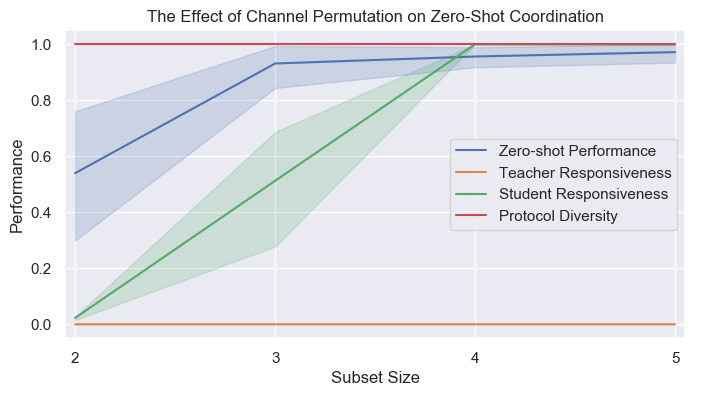

In [64]:
plt.figure(figsize=(8, 4))

sns.lineplot(x=X_NAME, y='Zero-Shot Coordination Score', 
             data=zs_coord_df, label='Zero-shot Performance')
sns.lineplot(x=X_NAME, y='Teacher Responsiveness', 
             data=eval_metrics_df, label='Teacher Responsiveness')
sns.lineplot(x=X_NAME, y='Student Responsiveness', 
             data=eval_metrics_df, label='Student Responsiveness')
sns.lineplot(x=X_NAME, y='Protocol Diversity', 
             data=eval_metrics_df, label='Protocol Diversity')

plt.ylim([-0.05, 1.05])

plt.xlim([1.95, CHANNEL_SIZE + .05])
plt.title('The Effect of Channel Permutation on Zero-Shot Coordination')
plt.ylabel('Performance')
plt.xlabel('Subset Size')
plt.xticks(pd.unique(zs_coord_df[X_NAME]))
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.legend(loc=4)
plt.show()

In [49]:
df_train = pd.DataFrame([
    {
        'Epoch': epoch,
        'Experiment': f"subset_size={item_1[experiment.param_name]}",
        'Subexperiment': f'subexperiment_{item_2["index"]}',
        'Train Loss': training_item['loss']
    }
    for item_1 in experiment.experiments
    for item_2 in item_1['experiment'].experiments
    for epoch, training_item in enumerate(item_2['experiment'].training_history) 
])
df_train.head()

,Epoch,Experiment,Subexperiment,Train Loss
0,0,subset_size=2,subexperiment_0,1.101373
1,1,subset_size=2,subexperiment_0,0.621002
2,2,subset_size=2,subexperiment_0,0.412464
3,3,subset_size=2,subexperiment_0,0.189280
4,4,subset_size=2,subexperiment_0,0.070556


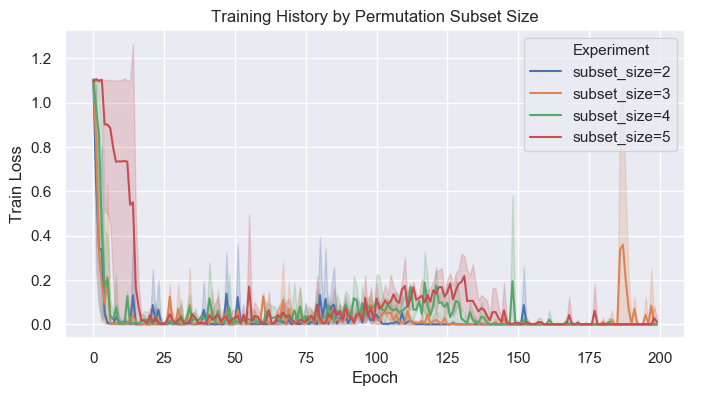

In [65]:
plt.figure(figsize=(8, 4))
sns.lineplot(x='Epoch', y='Train Loss', hue='Experiment', 
             data=df_train);
#              data=df_train[df_train['Experiment'] == 'p_m=0.2']);
# Put the legend out of the figure
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Training History by Permutation Subset Size')
plt.show()

In [101]:
df_test = pd.DataFrame([
    {
        'Epoch': epoch,
        'Experiment': f"subset_size={item_1[experiment.param_name]}",
        'Subexperiment': f'subexperiment_{item_2["index"]}',
        'Performance': training_item['test_metrics']['mean_ground_truth_f1'],
        'Protocol Diversity': training_item['test_metrics']['mean_protocol_diversity'],
    }
    for item_1 in experiment.experiments
    for item_2 in item_1['experiment'].experiments
    for epoch, training_item in enumerate(item_2['experiment'].training_history)
    if 'test_metrics' in training_item
] + [
    {
        'Epoch': epoch,
        'Experiment': f"subset_size={CHANNEL_SIZE}",
        'Subexperiment': f'subexperiment_{i}',
        'Performance': training_item['test_metrics']['mean_ground_truth_f1'],
        'Protocol Diversity': training_item['test_metrics']['mean_protocol_diversity'],
    }
    for i, experiment in enumerate(full_permutation_experiments)
    for epoch, training_item in enumerate(experiment.training_history) 
    if 'test_metrics' in training_item
])

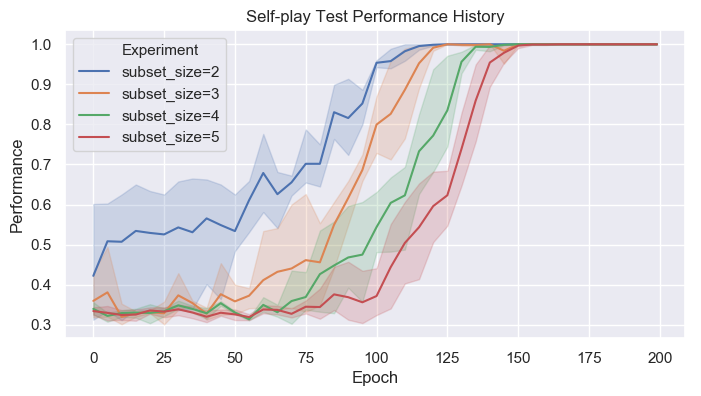

In [110]:
# fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plt.figure(figsize=(8, 4))
plt.title('Self-play Test Performance History')
sns.lineplot(x='Epoch', y='Performance', hue='Experiment', 
             data=df_test);
# sns.lineplot(x='Epoch', y='Protocol Diversity', hue='Experiment', 
#              data=df_test, ax=axs[1]);
#              data=df_test[df_test['Experiment'] == 'p_m=0.2']);
# Put the legend out of the figure
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()